## Подготовка данных

**Отключим** все предупреждения по инструкции

In [4]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max.columns", 100)
import pylab as plt

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

**Считаем** наш файл с данными

In [5]:
df = pd.read_csv("data/charts.csv")

**Распечатаем** первые 5 записи

In [6]:
df.head(5)

,track_id,name,country,date,position,streams,artists,artist_genres,duration,explicit
0,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-17,138,6584,['Maroon 5'],['pop'],239920,False
1,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-18,132,6963,['Maroon 5'],['pop'],239920,False
2,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-19,128,7049,['Maroon 5'],['pop'],239920,False
3,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-20,152,6976,['Maroon 5'],['pop'],239920,False
4,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-21,160,6156,['Maroon 5'],['pop'],239920,False


## Описание набора данных

In [7]:
print(df.shape)
print(df.columns.values)

(626475, 10)
['track_id' 'name' 'country' 'date' 'position' 'streams' 'artists'
 'artist_genres' 'duration' 'explicit']


Удалим '*track_id*' (сурогатный ключ) и ненужное поле ('*streams*')

In [8]:
df = df.drop(['track_id', 'streams'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626475 entries, 0 to 626474
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           626337 non-null  object
 1   country        626475 non-null  object
 2   date           626475 non-null  object
 3   position       626475 non-null  int64 
 4   artists        626475 non-null  object
 5   artist_genres  626475 non-null  object
 6   duration       626475 non-null  int64 
 7   explicit       626475 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 34.1+ MB


|     Название      | Описание                                       |      Тип       |
|---                |:--                                             |:--             |
| **name**          | Название песни                                 | категориальный |
| **country**       | Код страны, в которой появлялась песня в чарте | категориальный |
| **date**          | Дата появление в чарте                         | вещественный   |
| **position**      | Позиция в чарте                                | вещественный   |
| **artists**       | Авторы (исполнители) песни                     | категориальный |
| **artist_genres** | Жанры, в которых исполнители выступают         | категориальный |
| **duration**      | Длительность песни в (ms)                      | вещественный   |
| **explicit**      | Возрастное ограничение (есть/нет)              | бинарный       |

Целевая переменная **position** - Позиция в чарте (в зависимости от страны)

In [9]:
# Отдельно сохраним два list-а для удобства
print(f'TOP {df.position.max()}')
print(f'unique songs: {df.name.nunique()}')
print(f'unique artists: {df.artists.nunique()}')
print(f'unique countries: {df.country.nunique()}')

print(f'max duration: {df.duration.max()}')
print(f'min duration: {df.duration.min()}')

TOP 200
unique songs: 6854
unique artists: 3383
unique countries: 71
max duration: 943528
min duration: 0


## Очистка мусора

Дубликатов нет:

In [10]:
df.duplicated().sum()

0

Сразу заметим, что при вызове функции ***df.info()***, что кол-во строк в признаке **name** меньше, чем у остальных. 

Давайте проверим, ещё раз, на всякий случай, и взглянем, что внутри

In [11]:
df[df.isnull().any(axis=1)]

,name,country,date,position,artists,artist_genres,duration,explicit
122828,NaN,global,2017-11-09,32,['Various Artists'],[],0,True
122829,NaN,global,2017-11-10,30,['Various Artists'],[],0,True
122830,NaN,global,2017-11-11,26,['Various Artists'],[],0,True
122831,NaN,global,2017-11-12,27,['Various Artists'],[],0,True
122832,NaN,global,2017-11-13,31,['Various Artists'],[],0,True
...,...,...,...,...,...,...,...,...
122961,NaN,jp,2017-11-12,172,['Various Artists'],[],0,True
122962,NaN,jp,2017-11-13,177,['Various Artists'],[],0,True
122963,NaN,jp,2017-11-14,182,['Various Artists'],[],0,True
122964,NaN,hu,2017-11-11,164,['Various Artists'],[],0,True


Во всех этих строках длительность песни равна нулю. Очевидно, что эти данные нам не нужны, но перед удалением, изучим их поля: страну и позицию. Возможно, сможем предположить, почему какие-то даннные замусорились

Видим, что в странах JP (Япония) и HU(Венгрия) - возможно, специфичные языки не смогли отобразиться нашей в базе (иероглифы и пр). Давайте проверим

In [12]:
garbage = df[df.isnull().any(axis=1)]
garbage.country.unique()

array(['global', 'mx', 'ar', 'es', 'us', 'cl', 'pe', 'co', 'cr', 'it',
       'ec', 'nl', 'py', 'uy', 'gt', 'do', 'pa', 'bo', 'sv', 'ch', 'hn',
       'pt', 'jp', 'hu'], dtype=object)

Видим, что в списке оказались: США (us), Италия(it), Испания(es)

Странно, что тут США вообще делает, давайте посмотрим

In [13]:
garbage[garbage['country']=="us"].head(10)

,name,country,date,position,artists,artist_genres,duration,explicit
122852,NaN,us,2017-11-09,190,['Various Artists'],[],0,True
122853,NaN,us,2017-11-10,182,['Various Artists'],[],0,True
122854,NaN,us,2017-11-11,151,['Various Artists'],[],0,True
122855,NaN,us,2017-11-12,160,['Various Artists'],[],0,True
122856,NaN,us,2017-11-13,170,['Various Artists'],[],0,True
122857,NaN,us,2017-11-14,122,['Various Artists'],[],0,True


Возможно, какие-то странные ребята со странными названиями заскочили на 5 дней в чарты, либо возникли проблемы с лицензиями между исполнителями и Spotify

Напоследок, убедимся, не проходил ли кто-либо в топ-10:

In [14]:
garbage[garbage['position']<10].head()

,name,country,date,position,artists,artist_genres,duration,explicit
122834,NaN,mx,2017-11-09,2,['Various Artists'],[],0,True
122835,NaN,mx,2017-11-10,2,['Various Artists'],[],0,True
122836,NaN,mx,2017-11-11,2,['Various Artists'],[],0,True
122837,NaN,mx,2017-11-12,2,['Various Artists'],[],0,True
122838,NaN,mx,2017-11-13,2,['Various Artists'],[],0,True


Моё итоговое предположение - исполнители удалили свои песни или возникли проблемы в плане лицензии. Но я не уверен, тк, например, A$AP ROCKY, который был в топах яндекс музыки, наверняка, лежит где-то в бд по чартам 2012-2014 годов. Соц сети могут по 10 лет хранить личные данные, а важная информация, для отслеживания вкусов потребителей уж тем более не будет удаляться. Так и не пришёл к выводам - возможно, датасет с просто с косяками

**Очистим** лишний мусор

In [15]:
zero_duration = (df[df['duration']==0])
df = df.drop(zero_duration.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626337 entries, 0 to 626474
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           626337 non-null  object
 1   country        626337 non-null  object
 2   date           626337 non-null  object
 3   position       626337 non-null  int64 
 4   artists        626337 non-null  object
 5   artist_genres  626337 non-null  object
 6   duration       626337 non-null  int64 
 7   explicit       626337 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 38.8+ MB


## Визуальный анализ

Интересно проследить за спросом на отсутствие цензуры:

In [16]:
df["explicit"].value_counts()

False    367876
True     258461
Name: explicit, dtype: int64

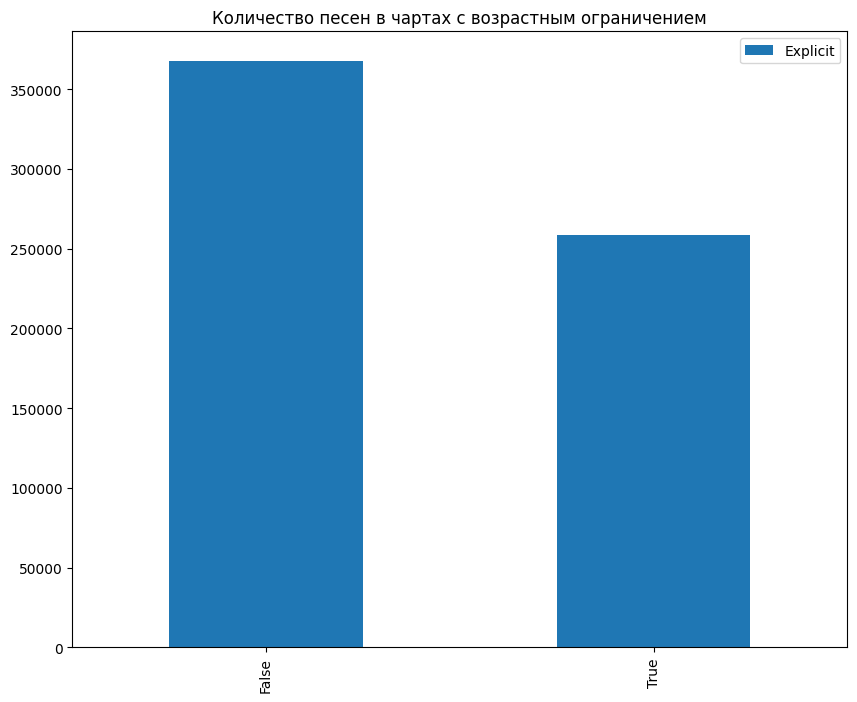

In [17]:
df["explicit"].value_counts().plot(kind="bar", label="Explicit")
plt.legend()
plt.title("Количество песен в чартах с возрастным ограничением");

Количественных переменных у нас не так много, поэтому не вижу смысла делать корреляцию

<AxesSubplot: >

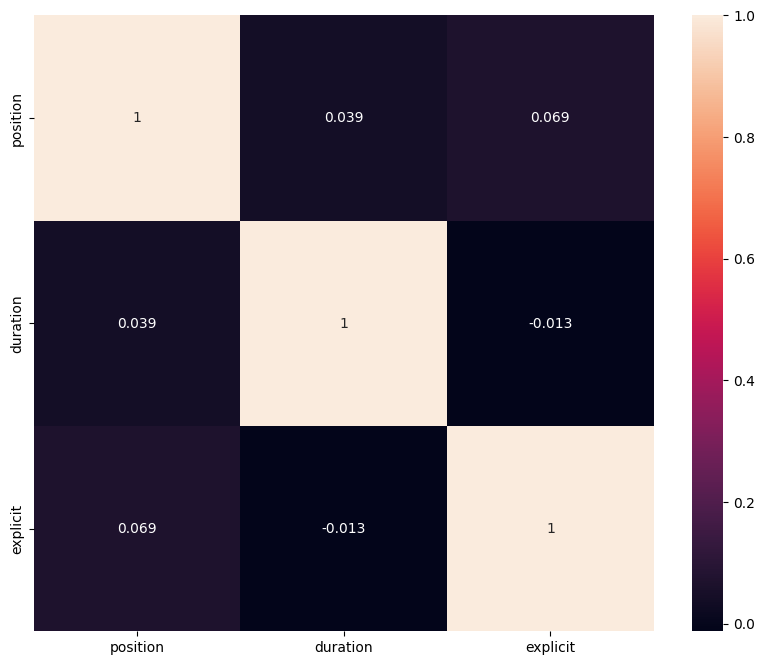

In [18]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

Видим, что везде **низкая корреляция** - логично, тк эти поля не особо связаны

Построим гистограмму для количественных значений и убедимся, что, в целом, ничего неожиданного:
- чем выше рейтинг, тем меньше песен
- средняя длительность трека : 350 секунд ~ 5-6 минут

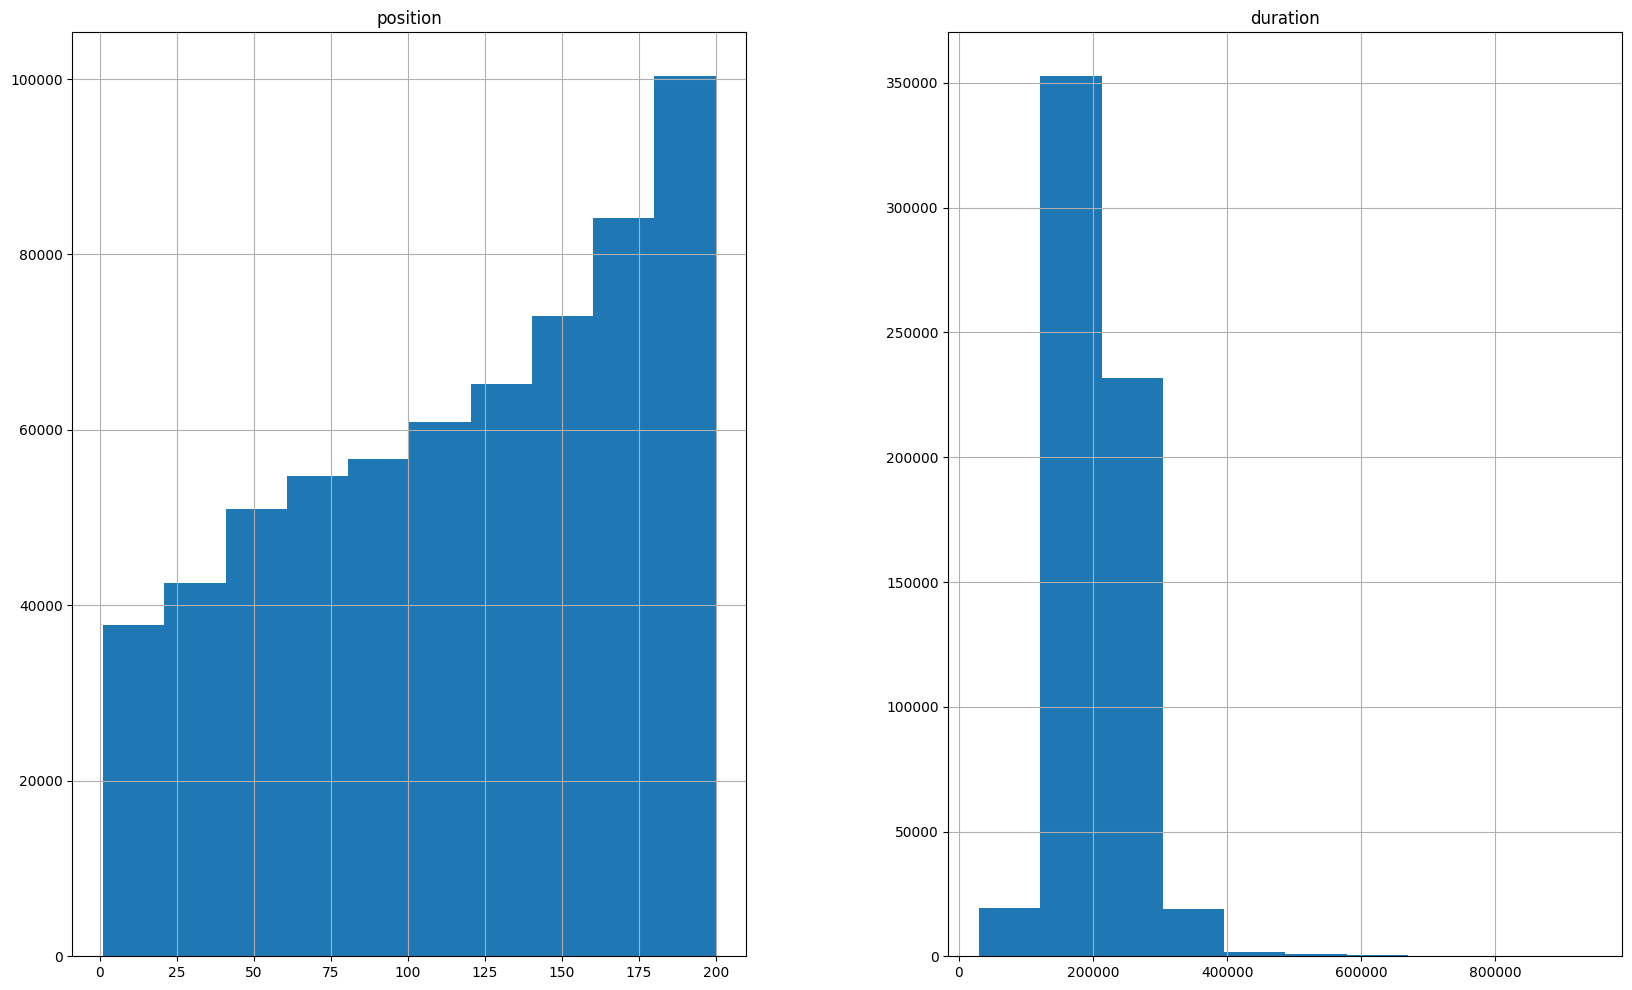

In [43]:
df.hist(figsize=(20, 12));

Найдём топ 10 стран, где активнее всего работает spotify, и проведём маленькую статистику:

In [71]:
# Из методички
# df.groupby(["country"])["position"].agg([np.mean]).sort_values(by="mean", ascending=False).

groupped_country = df.groupby(['country']).mean()
groupped_country = groupped_country.sort_values(by=['position'], ascending=False)
groupped_country[:10].head(10)

,position,duration,explicit
country,,,
br,137.184511,210721.211803,0.218801
tr,133.269947,222277.491689,0.264295
jp,131.965300,204318.017744,0.177050
us,131.610914,206732.509704,0.679633
id,131.419201,212912.387544,0.190979
in,127.537836,199372.418226,0.224166
ca,125.420636,206861.672861,0.604129
no,125.336354,207121.225554,0.348381
it,124.738148,208106.402604,0.250307


Интересно найти самого близкого по вкусам для РФ страну:

In [100]:
fresh_df = df[pd.DatetimeIndex(df['date']).year > 2018]
rus_df = fresh_df[fresh_df['country']=='ru']
not_rus_df = fresh_df[fresh_df['country']!='ru']

rus_df = rus_df.sort_values(by=['position'])
not_rus_df = exc_rus.sort_values(by=['position'])